# Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge
from keras.utils import plot_model
from IPython.display import SVG
import matplotlib.pyplot as plt
from keras.backend import reshape as Reshape

from keras.callbacks import EarlyStopping

# Data Load

In [4]:
dataset = pd.read_csv('user_movie_score_data.csv')

In [5]:
dataset.head(1)

,Unnamed: 0,score,user_idx,movie_index
0,0,10,77126,4095


# Preprocessing

## user

In [6]:
user_id = dataset['user_idx'].unique().tolist()
print(len(user_id))

82740


In [7]:
user2i = {u:i for i,u in enumerate(user_id)}
i2user = {i:u for i,u in enumerate(user_id)}

In [8]:
num_users = len(user2i) # user명에서 i로 변환된것을 사용

dataset 내의 모든 user에게 id 부여

## movie

In [9]:
movie_id = dataset['movie_index'].unique().tolist()

In [10]:
movie2i = {m:i for i,m in enumerate(movie_id)}
i2movie = {i:m for i,m in enumerate(movie_id)}

In [11]:
num_movies = len(i2movie) # 인덱스에서 movie로 변환된 것을 사용할 것

In [12]:
dataset = dataset.rename(columns={'score': 'rating', 'user_idx': 'user', 'movie_index':'movie'})
dataset.head()

,Unnamed: 0,rating,user,movie
0,0,10,77126,4095
1,1,10,55669,4095
2,2,9,39991,4095
3,3,5,50126,4095
4,4,10,62615,4095


In [13]:
dataset = dataset.iloc[:, [1,2,3]]
dataset.head()

,rating,user,movie
0,10,77126,4095
1,10,55669,4095
2,9,39991,4095
3,5,50126,4095
4,10,62615,4095


## ratings

In [14]:
dataset['rating'] = dataset['rating'].values
print(dataset['rating'])

0          10
1          10
2           9
3           5
4          10
           ..
6151098     8
6151099    10
6151100    10
6151101     1
6151102    10
Name: rating, Length: 6151103, dtype: int64


# Train/Val set 

- X_data = 예측에 사용되는 데이터셋. user, movie를 가지고 만든다  
- y_data = X_data를 가지고 수행한 것의 정답을 확인하기 위해 사용

In [15]:
X_data = dataset[['user','movie']]

In [16]:
y_data = dataset['rating']

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(4920882, 2)
(1230221, 2)
(4920882,)
(1230221,)


# Modeling

## Values in the originals

- Batch size: [128,256,512,1024]
- Learning Rate: [0.0001,0.0005,0.001,0.005]
- CF Layer: 32 -> 16 -> 8
- Emb size: 16

##### Review tesor

In [18]:
import torch
import numpy as np
a = torch.Tensor(np.arange(8).reshape(2,4))
b = torch.Tensor(np.arange(8).reshape(2,4))
a = np.asarray(a).astype('float32')
b = np.asarray(b).astype('float32')

print(f'a: {a}\n')
print(f'b: {b}\n')
print(f'resize: {Reshape(a, shape=(1,8))}\n')
print(f'Dot: {keras.layers.Dot(axes=1)([a,b])}\n')
print(f'element-wise dot: {a*b}\n')
print(f'concat: {layers.Concatenate(axis=0)([a,b])}\n')

a: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]]

b: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]]

resize: [[0. 1. 2. 3. 4. 5. 6. 7.]]

Dot: [[ 14.]
 [126.]]

element-wise dot: [[ 0.  1.  4.  9.]
 [16. 25. 36. 49.]]

concat: [[0. 1. 2. 3.]
 [4. 5. 6. 7.]
 [0. 1. 2. 3.]
 [4. 5. 6. 7.]]



## GMF  
  
Generalized Matrix Factorizations  


모델링

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [20]:
Embedding_size = 16

class GMF(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(GMF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed')
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)




    def call(self, inputs):
        
        user_vec = self.user_embedding(inputs[:,0])
        user_vec = Reshape(user_vec, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias = self.user_bias(inputs[:,0])

        movie_vec = self.movie_embedding(inputs[:,1])
        movie_vec = Reshape(movie_vec, shape = (-1, self.embedding_size))
        movie_bias = self.movie_bias(inputs[:,1])

        #dot =  keras.layers.Dot(axes=1)([user_vec, movie_vec])
        mat = user_vec * movie_vec
        x = mat + user_bias + movie_bias

        return x



test_model = GMF(num_users, num_movies, Embedding_size)
test_model.compile(loss = keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(lr=0.001), metrics=['RootMeanSquaredError'])

In [21]:
history = test_model.fit(X_train, y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),callbacks=[es])

Epoch 1/10
38445/38445 [==============================] - 233s 6ms/step - loss: -75.4721 - root_mean_squared_error: 7.1410 - val_loss: -101.5730 - val_root_mean_squared_error: 6.8152
Epoch 2/10
38445/38445 [==============================] - 228s 6ms/step - loss: -101.9391 - root_mean_squared_error: 6.7976 - val_loss: -102.0244 - val_root_mean_squared_error: 6.7934
Epoch 3/10
38445/38445 [==============================] - 227s 6ms/step - loss: -102.0850 - root_mean_squared_error: 6.7879 - val_loss: -102.0551 - val_root_mean_squared_error: 6.7910
Epoch 4/10
38445/38445 [==============================] - 225s 6ms/step - loss: -102.1028 - root_mean_squared_error: 6.7865 - val_loss: -102.0621 - val_root_mean_squared_error: 6.7905
Epoch 5/10
38445/38445 [==============================] - 225s 6ms/step - loss: -102.1117 - root_mean_squared_error: 6.7862 - val_loss: -102.0654 - val_root_mean_squared_error: 6.7903
Epoch 6/10
38445/38445 [==============================] - 225s 6ms/step - loss: -

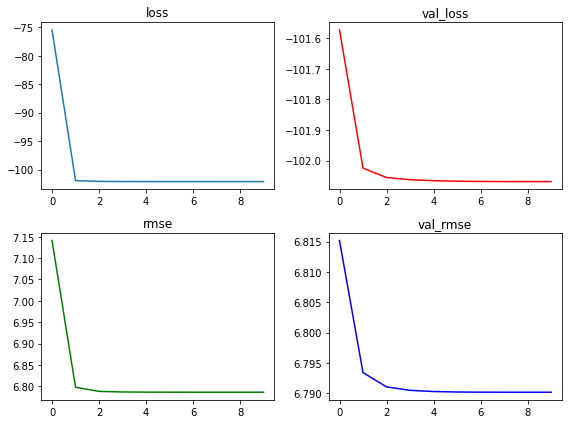

In [22]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

## MLP  
  
신경망을 이용한 파트

$\hat{y_{ui}} = \sigma(h^T a(p_u * q_u + W [p_{u_{1,1}}\  q_{u_{2,1}}] + b))$

In [23]:
Embedding_size = 8

class MLP(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.movie_bias = Embedding(num_movies,1)

        self.Layer1 = layers.Dense(16,activation='elu')
        self.Layer2 = layers.Dense(32,activation='elu')
        self.Layer3 = layers.Dense(16,activation='elu')
        self.Layer4 = layers.Dense(8,activation='elu')
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        
        user_vec = self.user_embedding(inputs[:,0])
        user_vec = Reshape(user_vec, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias = self.user_bias(inputs[:,0])

        movie_vec = self.movie_embedding(inputs[:,1])
        movie_vec = Reshape(movie_vec, shape = (-1, self.embedding_size))
        movie_bias = self.movie_bias(inputs[:,1])

        #dot =  keras.layers.Dot(axes=1)([user_vec, movie_vec])
        #mat = user_vec * movie_vec
        mat = keras.layers.Concatenate()([user_vec, movie_vec])
        x = mat + user_bias + movie_bias

        x = self.Layer1(x)
        x = self.dropout(x)
        x = self.Layer2(x)
        x = self.dropout(x)
        x = self.Layer3(x)
        x = self.dropout(x)

        return self.Layer4(x)



test_model2 = MLP(num_users, num_movies, Embedding_size)
test_model2.compile(loss = keras.losses.MeanAbsoluteError() ,optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['RootMeanSquaredError'])

In [24]:
history2 = test_model2.fit(X_train, y_train,batch_size=128,epochs=100,validation_data=(X_val,y_val),callbacks=[es])

Epoch 1/100
38445/38445 [==============================] - 106s 3ms/step - loss: 2.0426 - root_mean_squared_error: 2.9827 - val_loss: 1.9168 - val_root_mean_squared_error: 2.9204
Epoch 2/100
38445/38445 [==============================] - 106s 3ms/step - loss: 1.8919 - root_mean_squared_error: 2.9432 - val_loss: 1.8662 - val_root_mean_squared_error: 2.9442
Epoch 3/100
38445/38445 [==============================] - 106s 3ms/step - loss: 1.8526 - root_mean_squared_error: 2.9373 - val_loss: 1.8511 - val_root_mean_squared_error: 2.9269
Epoch 4/100
38445/38445 [==============================] - 106s 3ms/step - loss: 1.8372 - root_mean_squared_error: 2.9282 - val_loss: 1.8455 - val_root_mean_squared_error: 2.9328
Epoch 5/100
38445/38445 [==============================] - 106s 3ms/step - loss: 1.8279 - root_mean_squared_error: 2.9230 - val_loss: 1.8392 - val_root_mean_squared_error: 2.9343
Epoch 6/100
38445/38445 [==============================] - 106s 3ms/step - loss: 1.8215 - root_mean_squar

In [26]:
test_model2.save('MLP.h5py')

INFO:tensorflow:Assets written to: MLP.h5py/assets


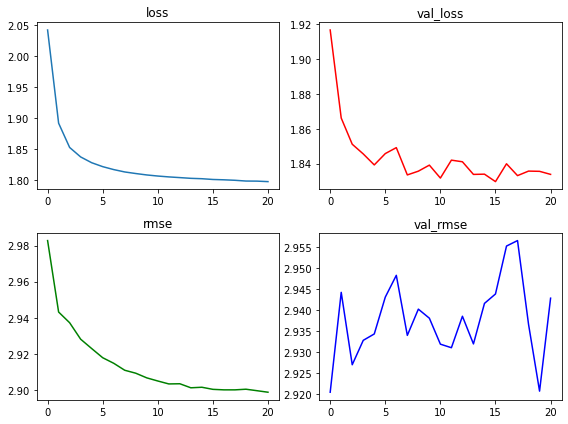

In [27]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history2.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history2.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history2.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history2.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

## Neu-MF  
  
Concatenate GMF and MLP parts

In [28]:
Embedding_size = 8

class Neu_MF(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(Neu_MF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = Embedding(num_users, Embedding_size, name='user_embed', embeddings_initializer= 'he_normal', embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.user_bias = Embedding(num_users,1)


        self.movie_embedding = Embedding(num_movies, Embedding_size, name='movie_embed')
        self.movie_bias = Embedding(num_movies,1)

        self.Layer1 = layers.Dense(16,activation='elu')
        self.Layer2 = layers.Dense(32,activation='elu')
        self.Layer3 = layers.Dense(16,activation='elu')
        self.Layer4 = layers.Dense(8,activation='elu')
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        
        # GMF

        user_vec_gmf = self.user_embedding(inputs[:,0])
        user_vec_gmf = Reshape(user_vec_gmf, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias_gmf = self.user_bias(inputs[:,0])

        movie_vec_gmf = self.movie_embedding(inputs[:,1])
        movie_vec_gmf = Reshape(movie_vec_gmf, shape = (-1, self.embedding_size))
        movie_bias_gmf = self.movie_bias(inputs[:,1])

        #mat_gmf = user_vec_gmf * movie_vec_gmf
        mat_gmf = keras.layers.merge.dot([user_vec_gmf, movie_vec_gmf], axes=1)
        gmf = mat_gmf + user_bias_gmf + movie_bias_gmf

        # MLP

        user_vec_mlp = self.user_embedding(inputs[:,0])
        user_vec_mlp = Reshape(user_vec_mlp, shape = (-1, self.embedding_size)) # # n>2 dim -> 2dim
        user_bias_mlp = self.user_bias(inputs[:,0])

        movie_vec_mlp = self.movie_embedding(inputs[:,1])
        movie_vec_mlp = Reshape(movie_vec_mlp, shape = (-1, self.embedding_size))
        movie_bias_mlp = self.movie_bias(inputs[:,1])

        # concat in MLP part

        concat_mlp = keras.layers.Concatenate()([user_vec_mlp, movie_vec_mlp])

        # MLP Layers
        x = self.dropout(self.Layer1(concat_mlp))
        x = self.dropout(self.Layer2(x))
        x = self.dropout(self.Layer3(x))
        mlp = x

        # concat MLP n GMF
        x = keras.layers.Concatenate()([gmf, mlp])

        # Final Prediction

        pred = self.Layer4(x)

        return pred

test_model3 = Neu_MF(num_users, num_movies, Embedding_size)
test_model3.compile(loss = keras.losses.MeanAbsoluteError(),optimizer=keras.optimizers.Nadam(lr=1e-3), metrics=['RootMeanSquaredError'])

In [29]:
history3 = test_model3.fit(X_train, y_train,batch_size=128,epochs=100,validation_data=(X_val,y_val),callbacks=[es])

Epoch 1/100
38445/38445 [==============================] - 225s 6ms/step - loss: 2.0002 - root_mean_squared_error: 2.9476 - val_loss: 1.8976 - val_root_mean_squared_error: 2.8775
Epoch 2/100
38445/38445 [==============================] - 225s 6ms/step - loss: 1.8808 - root_mean_squared_error: 2.8927 - val_loss: 1.8768 - val_root_mean_squared_error: 2.8920
Epoch 3/100
38445/38445 [==============================] - 225s 6ms/step - loss: 1.8655 - root_mean_squared_error: 2.8886 - val_loss: 1.8724 - val_root_mean_squared_error: 2.9066
Epoch 4/100
38445/38445 [==============================] - 225s 6ms/step - loss: 1.8594 - root_mean_squared_error: 2.8851 - val_loss: 1.8704 - val_root_mean_squared_error: 2.8940
Epoch 5/100
38445/38445 [==============================] - 225s 6ms/step - loss: 1.8557 - root_mean_squared_error: 2.8823 - val_loss: 1.8686 - val_root_mean_squared_error: 2.8980
Epoch 6/100
38445/38445 [==============================] - 225s 6ms/step - loss: 1.8530 - root_mean_squar

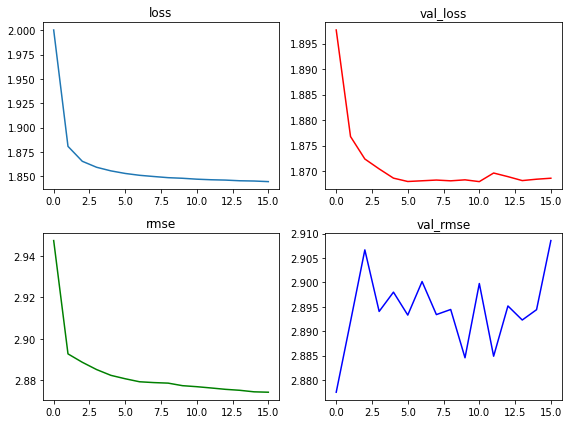

In [30]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history3.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history3.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('rmse') 
sub3.plot(history3.history['root_mean_squared_error'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_rmse') 
sub4.plot(history3.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

In [31]:
results = test_model3.evaluate(X_val,y_val, batch_size=128)
print("test loss", round(results[0],4))
print('test rmse',round(results[1],4))

9612/9612 [==============================] - 14s 2ms/step - loss: 1.8686 - root_mean_squared_error: 2.9085
test loss 1.8686
test rmse 2.9085


# Result


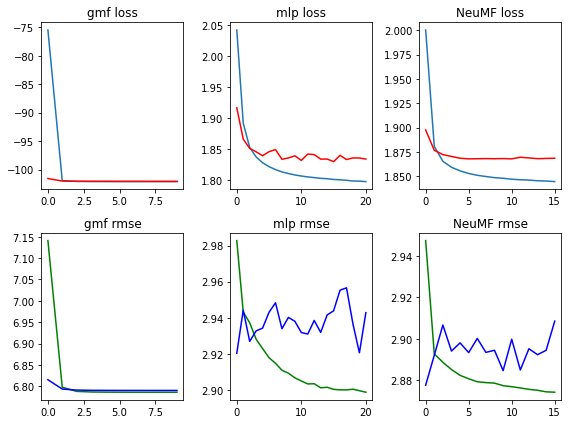

In [32]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(231) # instead of plt.subplot(2, 2, 1)
sub1.set_title('gmf loss') # non OOP: plt.title('The function f')
sub1.plot(history.history['loss'])
sub1.plot(history.history['val_loss'],c='red')

sub2 = fig.add_subplot(234) 
sub2.set_title('gmf rmse')
sub2.plot(history.history['root_mean_squared_error'],c='green')
sub2.plot(history.history['val_root_mean_squared_error'],c='blue')

sub3 = fig.add_subplot(232) # instead of plt.subplot(2, 2, 1)
sub3.set_title('mlp loss') # non OOP: plt.title('The function f')
sub3.plot(history2.history['loss'])
sub3.plot(history2.history['val_loss'],c='red')

sub4 = fig.add_subplot(235) 
sub4.set_title('mlp rmse')
sub4.plot(history2.history['root_mean_squared_error'],c='green')
sub4.plot(history2.history['val_root_mean_squared_error'],c='blue')

sub5 = fig.add_subplot(233) # instead of plt.subplot(2, 2, 1)
sub5.set_title('NeuMF loss') # non OOP: plt.title('The function f')
sub5.plot(history3.history['loss'])
sub5.plot(history3.history['val_loss'],c='red')

sub6 = fig.add_subplot(236) 
sub6.set_title('NeuMF rmse')
sub6.plot(history3.history['root_mean_squared_error'],c='green')
sub6.plot(history3.history['val_root_mean_squared_error'],c='blue')

plt.tight_layout()
plt.show()

In [33]:
test_model3.save_weights('NeuMF.h5')